<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install faiss-gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

In [4]:
import gc
import torch
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Read/Write to file

In [5]:
def read_bi_embeddings_from_file(filepath):
  indices, sources, targets = [], [], []

  with open(filepath) as f:
    for line in tqdm(f):
      strings = line.strip().split(",[")
      lists = [list(map(float, s.strip("[]").split(","))) for s in strings[1:]]
      source, target = lists
      index = int(strings[0])

      indices.append(index)
      sources.append(source)
      targets.append(target)

  bi_embeddings = {"indices" : indices,
                   "sources" : np.array(sources, dtype=np.single),
                   "targets" : np.array(targets, dtype=np.single)}
  return bi_embeddings

def read_onto_embeddings_from_file(filepath):
  indices, embeddings = [], None

  with open(filepath) as f:
    for line in tqdm(f):
      strings = line.strip().split(",[")
      embedding = np.array(list(map(float, strings[1].strip("[]").split(","))), dtype=np.single).reshape(1,-1)
      index = int(strings[0])

      indices.append(index)
      embeddings = embedding if embeddings is None else np.concatenate((embeddings, embedding), axis=0, dtype=np.single)

  onto_embeddings = {"indices"    : indices,
                     "embeddings" : embeddings}
  return onto_embeddings

# Faiss

In [12]:
def get_real_ranks(I, xq, xb, bi_embeddings):
  ranks = []
  for i in tqdm(range(len(xq))):
    source, target =  bi_embeddings["sources"][i],  bi_embeddings["targets"][i]
    for n, index in enumerate(I[i]):
      if np.array_equal(xb[index], target):
        ranks.append(n + 1)
        break
  return ranks

def plot_ranks(ranks, feature, negatives):
  plt.figure()
  plt.hist(ranks, bins=max(ranks) // 100)
  plt.xlabel("Subsumer rank")
  plt.ylabel("No. of queries")
  plt.title("Correct subsumer rank distribution across queries")
  plt.savefig(f"bi_ranking_histogram_{feature}_{negatives}.png")

def compute_result(ranks):
  result = {}

  raw_at_rank = lambda x: len([r for r in ranks if r <= x])
  hits_at_rank = lambda x: x / len(ranks)
  for r in [1, 5, 10, 50, 100, 1000]:
    score = hits_at_rank(raw_at_rank(r))
    result[f"H@{r}"] = score

  result["MRR"]     = np.mean(1 / np.array(ranks))
  result["Highest"] = np.min(ranks)
  result["Median"]  = np.median(ranks)
  result["Mean"]    = np.mean(ranks)
  result["Lowest"]  = np.max(ranks)

  return result

def pretty_print_result(result, feature, negatives):
  result_str = f"\nPerformance on ({feature}, {negatives}):\n\n"

  for (name, value) in result.items():
    if name.startswith("H@"):
      result_str += f"{name:<6} = {value:.3f}\n"
    elif name == "MRR":
      result_str += f"MRR    = {value:.3f}\n\n"
    else:
      result_str += f"{name}:" + " " * (13 - len(name)) + f"{value}\n"

  result_str += "\n"
  print(result_str)

642it [00:00, 1200.67it/s]
13848it [01:41, 136.76it/s]
100%|██████████| 642/642 [00:03<00:00, 186.95it/s]



Performance on (term, random):

H@1    = 0.000
H@5    = 0.003
H@10   = 0.013
H@50   = 0.071
H@100  = 0.155
H@1000 = 0.744
MRR    = 0.008

Highest:      3
Median:       373.0
Mean:         1042.76295133438
Lowest:       12259




652it [00:00, 1159.29it/s]
13848it [01:49, 126.63it/s]
100%|██████████| 652/652 [00:02<00:00, 268.16it/s]



Performance on (term, multi):

H@1    = 0.011
H@5    = 0.073
H@10   = 0.128
H@50   = 0.369
H@100  = 0.508
H@1000 = 0.875
MRR    = 0.053

Highest:      1
Median:       97.0
Mean:         555.703125
Lowest:       11262




643it [00:00, 1177.59it/s]
13848it [01:40, 137.35it/s]
100%|██████████| 643/643 [00:04<00:00, 151.96it/s]



Performance on (term, neighbour):

H@1    = 0.002
H@5    = 0.002
H@10   = 0.003
H@50   = 0.048
H@100  = 0.103
H@1000 = 0.616
MRR    = 0.006

Highest:      1
Median:       672.5
Mean:         1139.4015625
Lowest:       10567




642it [00:01, 438.76it/s]
13848it [01:42, 135.19it/s]
100%|██████████| 642/642 [00:32<00:00, 19.60it/s]



Performance on (ext, random):

H@1    = 0.000
H@5    = 0.028
H@10   = 0.071
H@50   = 0.318
H@100  = 0.450
H@1000 = 0.848
MRR    = 0.030

Highest:      2
Median:       129.0
Mean:         514.1469194312796
Lowest:       7477




652it [00:01, 526.37it/s]
13848it [01:43, 134.34it/s]
100%|██████████| 652/652 [00:35<00:00, 18.48it/s]



Performance on (ext, multi):

H@1    = 0.055
H@5    = 0.286
H@10   = 0.423
H@50   = 0.742
H@100  = 0.863
H@1000 = 0.989
MRR    = 0.177

Highest:      1
Median:       14.5
Mean:         118.46153846153847
Lowest:       5714




643it [00:01, 486.02it/s]
13848it [01:41, 136.85it/s]
100%|██████████| 643/643 [00:35<00:00, 17.98it/s]



Performance on (ext, neighbour):

H@1    = 0.000
H@5    = 0.005
H@10   = 0.005
H@50   = 0.049
H@100  = 0.081
H@1000 = 0.562
MRR    = 0.007

Highest:      2
Median:       800.0
Mean:         892.7513513513513
Lowest:       3858




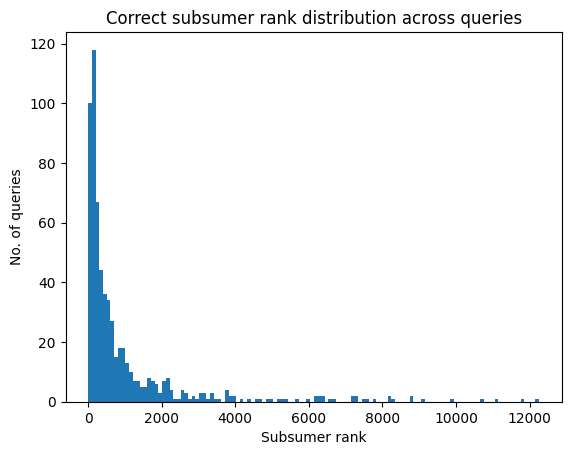

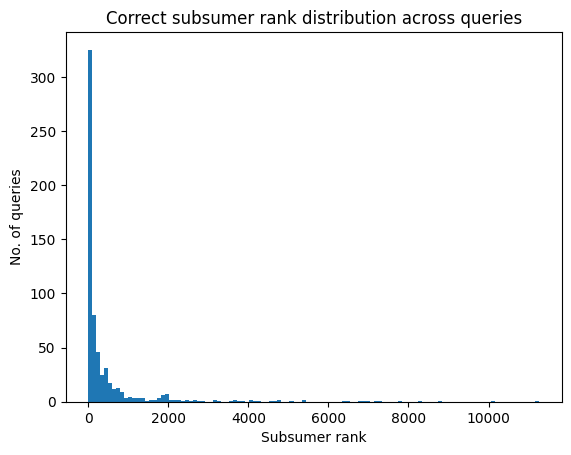

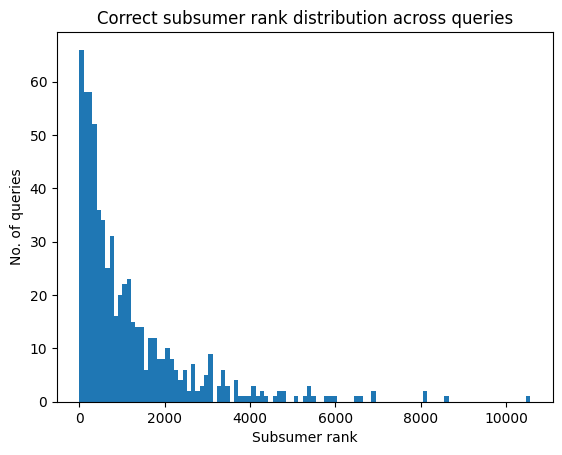

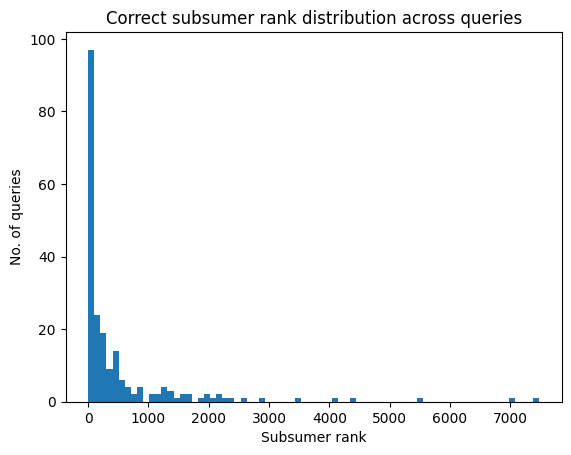

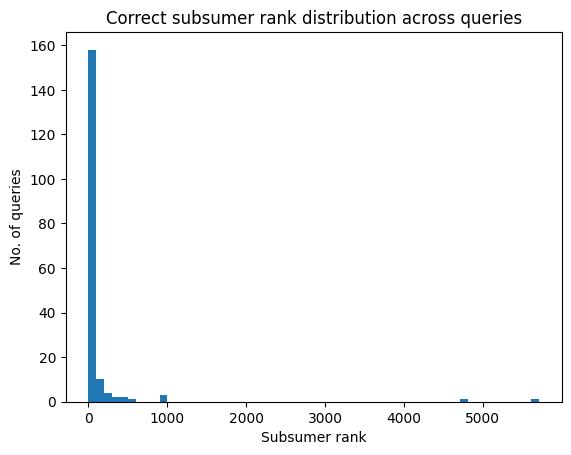

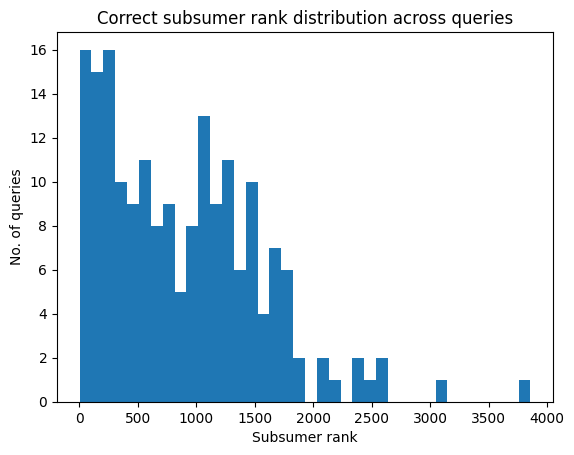

In [13]:
dir = ""
dir = "/content/drive/MyDrive/embeddings/"
features = ['term', 'ext']
negative_sampling = ['random', 'multi', 'neighbour']
results_df = pd.DataFrame(columns=["H@1", "H@5", "H@10", "H@50", "H@100", "H@1000", "MRR", "Highest", "Median", "Mean", "Lowest"])

for feature in features:
  for negatives in negative_sampling:
    bi_embeddings = read_bi_embeddings_from_file(f"{dir}bi_embeddings_{feature}_{negatives}.csv")
    onto_embeddings = read_onto_embeddings_from_file(f"{dir}doid_embeddings_{feature}_{negatives}.csv")

    xq = bi_embeddings["sources"]
    xb = onto_embeddings["embeddings"]
    d = xb[0].shape[0]

    q_size = len(xq)
    db_size = len(xb)

    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatIP(d)
    index_flat.add(xb)
    D, I = index_flat.search(xq, db_size)

    ranks = get_real_ranks(I, xq, xb, bi_embeddings)
    plot_ranks(ranks, feature, negatives)
    result = compute_result(ranks)
    pretty_print_result(result, feature, negatives)

    results_df.loc[f"{feature},{negatives}"] = result

results_df.to_csv("bi_ranking_results.csv")